In [1]:
import platform
import tensorflow
import keras
print("Platform: {}".format(platform.platform()))
print("Tensorflow version: {}".format(tensorflow.__version__))
print("Keras version: {}".format(keras.__version__))

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from IPython.display import Image

Platform: Linux-4.4.0-159-generic-x86_64-with-debian-stretch-sid
Tensorflow version: 1.14.0
Keras version: 2.2.5


Using TensorFlow backend.


In [2]:
import os, shutil

class MkDir(object):
    DATA_PATH = os.path.join(os.getcwd(), 'data')
    base_dir = os.path.join(DATA_PATH, 'cats_and_dogs_small')
    original_dataset_dir = os.path.join(DATA_PATH, 'train')
    
    def __init__(self, sub_dir, cat, start=0, total_img=1000):
        self.path = os.path.join(self.base_dir, sub_dir, cat)
        self.sub_dir = sub_dir
        self.cat = cat
        self.total_img = total_img
        self.start = start
        
    def make_dir(self):
        if not os.path.exists(self.path):
            os.makedirs(self.path)
    
    def copy_img(self):
        end = self.start + self.total_img
        fnames = [self.cat+'.{}.jpg'.format(i) for i in range(self.start, end)]
        for fname in fnames:
            src = os.path.join(self.original_dataset_dir, fname)
            dst = os.path.join(self.path, fname)
            if not os.path.exists(dst):
                shutil.copyfile(src, dst)
        self._len = len(os.listdir(self.path))
    
    @property
    def length(self):
        return self.sub_dir + ' ' + self.cat + ' has ' + str(self._len) + ' images.'
      

In [3]:
# Prepare data
cat_train = MkDir('train', 'cat')
cat_train.make_dir()
cat_train.copy_img()
print(cat_train.length)

dog_train = MkDir('train', 'dog')
dog_train.make_dir()
dog_train.copy_img()
print(dog_train.length)

cat_val = MkDir('validation', 'cat', 1000, 500)
cat_val.make_dir()
cat_val.copy_img()
print(cat_val.length)

dog_val = MkDir('validation', 'dog', 1000, 500)
dog_val.make_dir()
dog_val.copy_img()
print(dog_val.length)

cat_test = MkDir('test', 'cat', 1500, 500)
cat_test.make_dir()
cat_test.copy_img()
print(cat_test.length)

dog_test = MkDir('test', 'dog', 1500, 500)
dog_test.make_dir()
dog_test.copy_img()
print(dog_test.length)

train cat has 1000 images.
train dog has 1000 images.
validation cat has 500 images.
validation dog has 500 images.
test cat has 500 images.
test dog has 500 images.


# Feature Extraction

![feature extraction](https://camo.githubusercontent.com/2de162f6f3587a0422389355909594413ae17742/68747470733a2f2f73332e616d617a6f6e6177732e636f6d2f626f6f6b2e6b657261732e696f2f696d672f6368352f7377617070696e675f66635f636c61737369666965722e706e67)

Available pretrained keras model on ImageNet:
- Xception
- InceptionV3
- ResNet50
- VGG16
- VGG19
- MobileNet

In [4]:
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet', 
                  include_top=False,  # discard top layers
                  input_shape=(150, 150, 3)
                 )

W0909 16:48:17.337268 140530456942336 deprecation_wrapper.py:119] From /hpc/home/ephyan/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0909 16:48:17.351019 140530456942336 deprecation_wrapper.py:119] From /hpc/home/ephyan/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0909 16:48:17.352985 140530456942336 deprecation_wrapper.py:119] From /hpc/home/ephyan/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4432: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0909 16:48:17.375975 140530456942336 deprecation_wrapper.py:119] From /hpc/home/ephyan/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4267: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d i

In [5]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

## Conv base: feature extraction + dense layer classifier -> retrain the dense layer classifier

In [6]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1/255)
BATCH_SIZE = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    
    # Image generator
    generator = datagen.flow_from_directory(
        directory, 
        batch_size=BATCH_SIZE, 
        target_size=(150, 150), 
        class_mode='binary')
    
    for i, (inputs_batch, labels_batch) in enumerate(generator):
        features_batch = conv_base.predict(inputs_batch)
        features[i * BATCH_SIZE : (i + 1) * BATCH_SIZE] = features_batch  # Save the features
        labels[i * BATCH_SIZE : (i + 1) * BATCH_SIZE] = labels_batch
        
        if (i+1) * BATCH_SIZE >= sample_count:
            # The data generator will generate infinite samples if not break
            break
    print('feature extraction complete')
    return features, labels

base_dir = os.path.join(os.getcwd(), 'data', 'cats_and_dogs_small')

train_dir = os.path.join(base_dir, 'train')
train_features, train_labels = extract_features(train_dir, 2000)

val_dir = os.path.join(base_dir, 'validation')
val_features, val_labels = extract_features(val_dir, 1000)

test_dir = os.path.join(base_dir, 'test')
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
feature extraction complete
Found 1000 images belonging to 2 classes.
feature extraction complete
Found 1000 images belonging to 2 classes.
feature extraction complete


In [7]:
train_features = train_features.reshape(2000, 4 * 4 * 512)
val_features = val_features.reshape(1000, 4 * 4 * 512)
test_features = test_features.reshape(1000, 4 * 4 * 512)

In [8]:
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim = 4*4*512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5), 
              loss='binary_crossentropy', 
              metrics=['acc'])

history = model.fit(train_features, train_labels, 
                   epochs=30, 
                   batch_size=20,
                   validation_data=(val_features, val_labels))

W0909 16:50:27.532524 140530456942336 deprecation.py:506] From /hpc/home/ephyan/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3733: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
W0909 16:50:27.568368 140530456942336 deprecation_wrapper.py:119] From /hpc/home/ephyan/anaconda3/lib/python3.7/site-packages/keras/optimizers.py:793: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0909 16:50:27.576537 140530456942336 deprecation.py:323] From /hpc/home/ephyan/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broa

Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 2s 1ms/step - loss: 0.6045 - acc: 0.6790 - val_loss: 0.4440 - val_acc: 0.8220
Epoch 2/30
2000/2000 [==============================] - 2s 1ms/step - loss: 0.4333 - acc: 0.7965 - val_loss: 0.3618 - val_acc: 0.8660
Epoch 3/30
2000/2000 [==============================] - 2s 931us/step - loss: 0.3584 - acc: 0.8475 - val_loss: 0.3222 - val_acc: 0.8830
Epoch 4/30
2000/2000 [==============================] - 2s 1ms/step - loss: 0.3195 - acc: 0.8695 - val_loss: 0.2986 - val_acc: 0.8850
Epoch 5/30
2000/2000 [==============================] - 2s 1ms/step - loss: 0.2855 - acc: 0.8890 - val_loss: 0.2844 - val_acc: 0.8910
Epoch 6/30
2000/2000 [==============================] - 2s 1ms/step - loss: 0.2643 - acc: 0.8900 - val_loss: 0.2732 - val_acc: 0.8900
Epoch 7/30
2000/2000 [==============================] - 2s 1ms/step - loss: 0.2533 - acc: 0.8980 - val_loss: 0.2654 - val_acc: 0.8930
Epoch 8/30
2

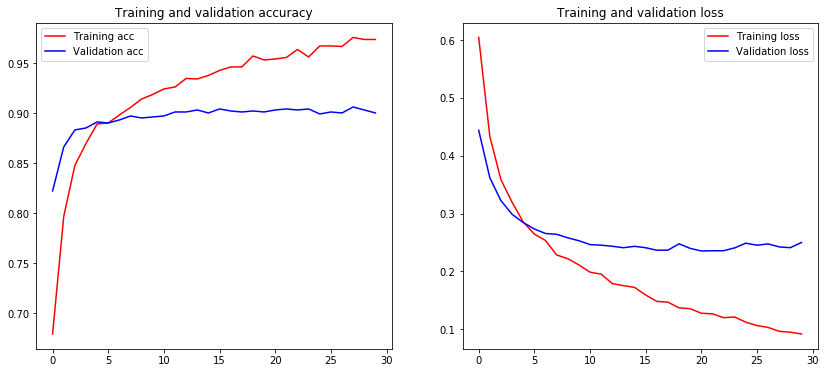

In [9]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.figure(figsize=(14, 6))
plt.subplot(121)
plt.plot(epochs, acc, 'r-', label='Training acc')
plt.plot(epochs, val_acc, 'b-', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.subplot(122)
plt.plot(epochs, loss, 'r-', label='Training loss')
plt.plot(epochs, val_loss, 'b-', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Freeze conv base and connect with new dense layers -> retrain end to end

In [10]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [11]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


In [12]:
print('Trainable weights before freezing the conv base: ', len(model.trainable_weights))

Trainable weights before freezing the conv base:  30


In [13]:
# Freeze the conv base
conv_base.trainable = False

# 4 weights are trainable after freezing: w and bias for each layer, and 2 layers are trainable
print('Trainable weights after freezing the conv base: ', len(model.trainable_weights))

Trainable weights after freezing the conv base:  4


In [14]:
# Include data argumentation
train_datagen = ImageDataGenerator(
        rescale=1/255,
        rotation_range=40,
        width_shift_range=.2,
        height_shift_range=.2,
        zoom_range=.2,
        shear_range=.2,
        horizontal_flip=True,
        fill_mode='nearest')

test_gen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary'
        )

val_generator = train_datagen.flow_from_directory(
        val_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary'
        )

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit_generator(
    train_generator, 
    steps_per_epoch=100, 
    epochs=30, 
    validation_data=val_generator, 
    validation_steps=50, 
    use_multiprocessing=True,
    verbose=2)


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/30
 - 108s - loss: 0.5920 - acc: 0.6930 - val_loss: 0.5125 - val_acc: 0.7710
Epoch 2/30
 - 104s - loss: 0.4758 - acc: 0.7885 - val_loss: 0.4553 - val_acc: 0.7960
Epoch 3/30
 - 103s - loss: 0.4211 - acc: 0.8165 - val_loss: 0.4254 - val_acc: 0.8110
Epoch 4/30
 - 102s - loss: 0.3998 - acc: 0.8285 - val_loss: 0.3908 - val_acc: 0.8410
Epoch 5/30
 - 102s - loss: 0.3834 - acc: 0.8330 - val_loss: 0.3801 - val_acc: 0.8300
Epoch 6/30
 - 103s - loss: 0.3610 - acc: 0.8385 - val_loss: 0.3766 - val_acc: 0.8380
Epoch 7/30
 - 105s - loss: 0.3445 - acc: 0.8465 - val_loss: 0.3723 - val_acc: 0.8250
Epoch 8/30
 - 104s - loss: 0.3359 - acc: 0.8625 - val_loss: 0.3820 - val_acc: 0.8290
Epoch 9/30
 - 103s - loss: 0.3393 - acc: 0.8475 - val_loss: 0.3467 - val_acc: 0.8450
Epoch 10/30
 - 102s - loss: 0.3463 - acc: 0.8465 - val_loss: 0.3520 - val_acc: 0.8560
Epoch 11/30
 - 104s - loss: 0.3365 - acc: 0.8500 - val_loss: 0.32

In [15]:
model.save('cats_vs_dogs_small_3.h5')

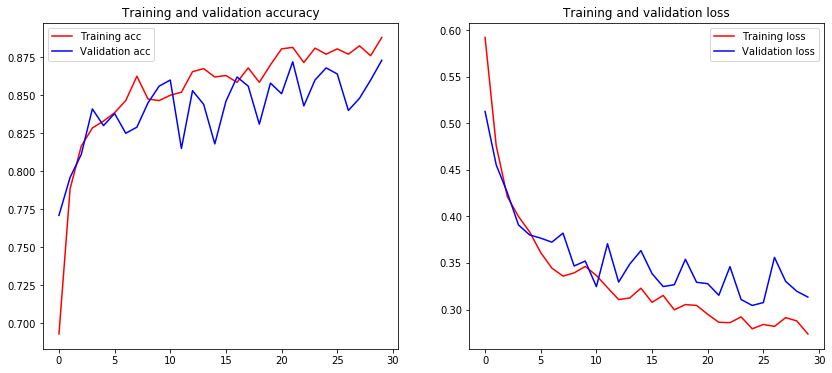

In [16]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.figure(figsize=(14, 6))
plt.subplot(121)
plt.plot(epochs, acc, 'r-', label='Training acc')
plt.plot(epochs, val_acc, 'b-', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.subplot(122)
plt.plot(epochs, loss, 'r-', label='Training loss')
plt.plot(epochs, val_loss, 'b-', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Fine-tuning

Steps of fine-tuning:
1. Add customized layers on top of conv base
2. Freeze the conv base and train the customised layers
3. Unfreeze some layers in conv base
4. Train the unfrozen conv layers with customized layers together

In [17]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [18]:
# Unfreeze conv base
conv_base.trainable = True

# Freeze bottom layers until block4_pool (included). Layers at block5 should be unfrozen
layers_unfrozen = ['block5_conv1', 'block5_conv2', 'block5_conv3', 'block5_pool']
for layer in conv_base.layers:
    if layer.name in layers_unfrozen:
        layer.trainable = True
    else:
        layer.trainable = False
        
for layer in conv_base.layers:
    print('{}: {}'.format(layer.name, layer.trainable))

input_1: False
block1_conv1: False
block1_conv2: False
block1_pool: False
block2_conv1: False
block2_conv2: False
block2_pool: False
block3_conv1: False
block3_conv2: False
block3_conv3: False
block3_pool: False
block4_conv1: False
block4_conv2: False
block4_conv3: False
block4_pool: False
block5_conv1: True
block5_conv2: True
block5_conv3: True
block5_pool: True


In [19]:
model.compile(optimizer=optimizers.RMSprop(lr=2e-5), 
              loss='binary_crossentropy', 
              metrics=['acc'])

history = model.fit_generator(
        train_generator,
        steps_per_epoch=100,
        epochs=30,
        validation_data=val_generator,
        validation_steps=50)

Epoch 1/30
100/100 [==============================] - 131s 1s/step - loss: 0.3422 - acc: 0.8535 - val_loss: 0.3949 - val_acc: 0.8340
Epoch 2/30
100/100 [==============================] - 134s 1s/step - loss: 0.2772 - acc: 0.8800 - val_loss: 0.2912 - val_acc: 0.8780
Epoch 3/30
100/100 [==============================] - 135s 1s/step - loss: 0.2618 - acc: 0.8835 - val_loss: 0.3185 - val_acc: 0.8460
Epoch 4/30
100/100 [==============================] - 134s 1s/step - loss: 0.2415 - acc: 0.8995 - val_loss: 0.2839 - val_acc: 0.8730
Epoch 5/30
100/100 [==============================] - 132s 1s/step - loss: 0.2364 - acc: 0.9065 - val_loss: 0.2583 - val_acc: 0.9000
Epoch 6/30
100/100 [==============================] - 129s 1s/step - loss: 0.2091 - acc: 0.9155 - val_loss: 0.2478 - val_acc: 0.8970
Epoch 7/30
100/100 [==============================] - 129s 1s/step - loss: 0.1956 - acc: 0.9190 - val_loss: 0.2965 - val_acc: 0.8810
Epoch 8/30
100/100 [==============================] - 126s 1s/step - 

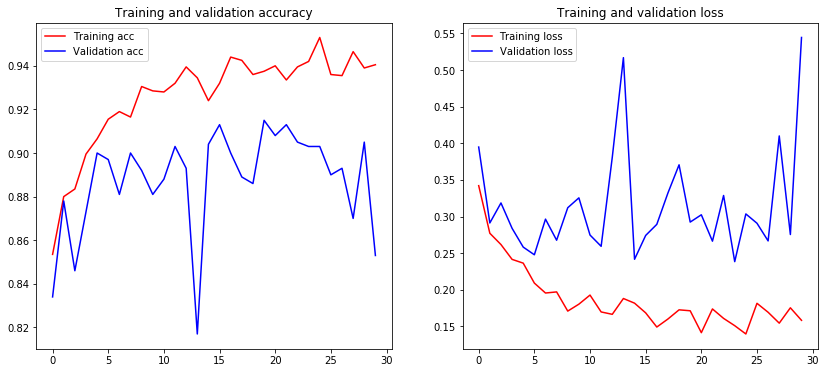

In [20]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.figure(figsize=(14, 6))
plt.subplot(121)
plt.plot(epochs, acc, 'r-', label='Training acc')
plt.plot(epochs, val_acc, 'b-', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.subplot(122)
plt.plot(epochs, loss, 'r-', label='Training loss')
plt.plot(epochs, val_loss, 'b-', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

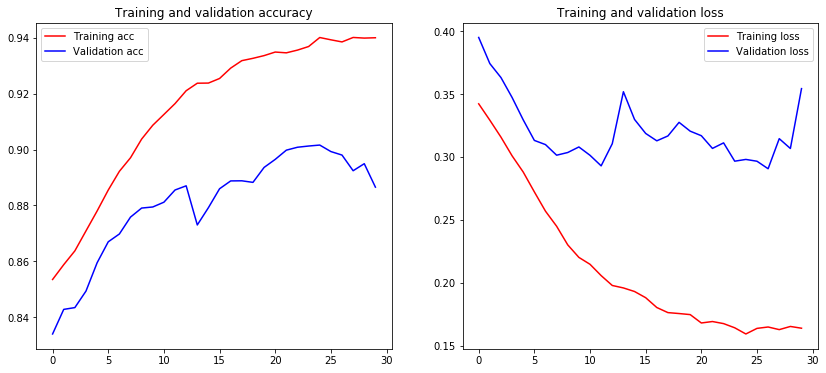

In [22]:
# The fig above contains too much noise
# We smooth it

def smooth_curve(points, factor=.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points
            
plt.figure(figsize=(14, 6))
plt.subplot(121)
plt.plot(epochs, smooth_curve(acc), 'r-', label='Training acc')
plt.plot(epochs, smooth_curve(val_acc), 'b-', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.subplot(122)
plt.plot(epochs, smooth_curve(loss), 'r-', label='Training loss')
plt.plot(epochs, smooth_curve(val_loss), 'b-', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()